### 1. 电影特征

In [1]:
import paddle
movie_info = paddle.dataset.movielens.movie_info()
print movie_info.values()[0]

<MovieInfo id(1), title(Toy Story ), categories([u'Animation', u"Children's", u'Comedy'])>


### 2. 用户特征

In [2]:
user_info = paddle.dataset.movielens.user_info()
print user_info.values()[0]

<UserInfo id(1), gender(F), age(1), job(10)>


### 3. 对于每一条训练/测试数据，均为 <用户特征> + <电影特征> + 评分

In [3]:
train_set_creator = paddle.dataset.movielens.train()
train_sample = next(train_set_creator())
uid = train_sample[0]
mov_id = train_sample[len(user_info[uid].value())]
print "User %s rates Movie %s with Score %s"%(user_info[uid], movie_info[mov_id], train_sample[-1])

User <UserInfo id(1), gender(F), age(1), job(10)> rates Movie <MovieInfo id(1193), title(One Flew Over the Cuckoo's Nest ), categories([u'Drama'])> with Score [5.0]


### 4. 模型配置说明
下面我们开始根据输入数据的形式配置模型。首先引入所需的库函数以及定义全局变量。

In [4]:
from __future__ import print_function
import math
import sys
import numpy as np
import paddle
import paddle.fluid as fluid
import paddle.fluid.layers as layers
import paddle.fluid.nets as nets

IS_SPARSE = True
USE_GPU = False
BATCH_SIZE = 256

### 4.2 然后为我们的用户特征综合模型定义模型配置

In [5]:
def get_usr_combined_features():

    USR_DICT_SIZE = paddle.dataset.movielens.max_user_id() + 1

    uid = layers.data(name='user_id', shape=[1], dtype='int64')

    usr_emb = layers.embedding(
        input=uid,
        dtype='float32',
        size=[USR_DICT_SIZE, 32],
        param_attr='user_table',
        is_sparse=IS_SPARSE)

    usr_fc = layers.fc(input=usr_emb, size=32)

    USR_GENDER_DICT_SIZE = 2

    usr_gender_id = layers.data(name='gender_id', shape=[1], dtype='int64')

    usr_gender_emb = layers.embedding(
        input=usr_gender_id,
        size=[USR_GENDER_DICT_SIZE, 16],
        param_attr='gender_table',
        is_sparse=IS_SPARSE)

    usr_gender_fc = layers.fc(input=usr_gender_emb, size=16)

    USR_AGE_DICT_SIZE = len(paddle.dataset.movielens.age_table)
    usr_age_id = layers.data(name='age_id', shape=[1], dtype="int64")

    usr_age_emb = layers.embedding(
        input=usr_age_id,
        size=[USR_AGE_DICT_SIZE, 16],
        is_sparse=IS_SPARSE,
        param_attr='age_table')

    usr_age_fc = layers.fc(input=usr_age_emb, size=16)

    USR_JOB_DICT_SIZE = paddle.dataset.movielens.max_job_id() + 1
    usr_job_id = layers.data(name='job_id', shape=[1], dtype="int64")

    usr_job_emb = layers.embedding(
        input=usr_job_id,
        size=[USR_JOB_DICT_SIZE, 16],
        param_attr='job_table',
        is_sparse=IS_SPARSE)

    usr_job_fc = layers.fc(input=usr_job_emb, size=16)

    concat_embed = layers.concat(
        input=[usr_fc, usr_gender_fc, usr_age_fc, usr_job_fc], axis=1)

    usr_combined_features = layers.fc(input=concat_embed, size=200, act="tanh")

    return usr_combined_features

### 4.3 对每一个电影特征做类似的变换

In [6]:
def get_mov_combined_features():

    MOV_DICT_SIZE = paddle.dataset.movielens.max_movie_id() + 1

    mov_id = layers.data(name='movie_id', shape=[1], dtype='int64')

    mov_emb = layers.embedding(
        input=mov_id,
        dtype='float32',
        size=[MOV_DICT_SIZE, 32],
        param_attr='movie_table',
        is_sparse=IS_SPARSE)

    mov_fc = layers.fc(input=mov_emb, size=32)

    CATEGORY_DICT_SIZE = len(paddle.dataset.movielens.movie_categories())

    category_id = layers.data(
        name='category_id', shape=[1], dtype='int64', lod_level=1)

    mov_categories_emb = layers.embedding(
        input=category_id, size=[CATEGORY_DICT_SIZE, 32], is_sparse=IS_SPARSE)

    mov_categories_hidden = layers.sequence_pool(
        input=mov_categories_emb, pool_type="sum")

    MOV_TITLE_DICT_SIZE = len(paddle.dataset.movielens.get_movie_title_dict())

    mov_title_id = layers.data(
        name='movie_title', shape=[1], dtype='int64', lod_level=1)

    mov_title_emb = layers.embedding(
        input=mov_title_id, size=[MOV_TITLE_DICT_SIZE, 32], is_sparse=IS_SPARSE)

    mov_title_conv = nets.sequence_conv_pool(
        input=mov_title_emb,
        num_filters=32,
        filter_size=3,
        act="tanh",
        pool_type="sum")

    concat_embed = layers.concat(
        input=[mov_fc, mov_categories_hidden, mov_title_conv], axis=1)

    mov_combined_features = layers.fc(input=concat_embed, size=200, act="tanh")

    return mov_combined_features

### 4.4 我们定义一个inference_program来使用余弦相似度计算用户特征与电影特征的相似性

In [7]:
def inference_program():
    usr_combined_features = get_usr_combined_features()
    mov_combined_features = get_mov_combined_features()

    inference = layers.cos_sim(X=usr_combined_features, Y=mov_combined_features)
    scale_infer = layers.scale(x=inference, scale=5.0)

    return scale_infer

In [8]:
def train_program():

    scale_infer = inference_program()

    label = layers.data(name='score', shape=[1], dtype='float32')
    square_cost = layers.square_error_cost(input=scale_infer, label=label)
    avg_cost = layers.mean(square_cost)

    return [avg_cost, scale_infer]


def optimizer_func():
    return fluid.optimizer.SGD(learning_rate=0.2)

### 5. train model

In [9]:
use_cuda = False
place = fluid.CUDAPlace(0) if use_cuda else fluid.CPUPlace()

In [10]:
train_reader = paddle.batch(
    paddle.reader.shuffle(
        paddle.dataset.movielens.train(), buf_size=8192),
    batch_size=BATCH_SIZE)

test_reader = paddle.batch(
    paddle.dataset.movielens.test(), batch_size=BATCH_SIZE)

In [11]:
feed_order = [
    'user_id', 'gender_id', 'age_id', 'job_id', 'movie_id', 'category_id',
    'movie_title', 'score'
]

In [12]:
main_program = fluid.default_main_program()
star_program = fluid.default_startup_program()
[avg_cost, scale_infer] = train_program()

test_program = main_program.clone(for_test=True)
sgd_optimizer = optimizer_func()
sgd_optimizer.minimize(avg_cost)
exe = fluid.Executor(place)

def train_test(program, reader):
    count = 0
    feed_var_list = [
        program.global_block().var(var_name) for var_name in feed_order
    ]
    feeder_test = fluid.DataFeeder(
    feed_list=feed_var_list, place=place)
    test_exe = fluid.Executor(place)
    accumulated = len([avg_cost, scale_infer]) * [0]
    for test_data in reader():
        avg_cost_np = test_exe.run(program=program,
                                               feed=feeder_test.feed(test_data),
                                               fetch_list=[avg_cost, scale_infer])
        accumulated = [x[0] + x[1][0] for x in zip(accumulated, avg_cost_np)]
        count += 1
    return [x / count for x in accumulated]


In [15]:
PASS_NUM = 10
# Specify the directory path to save the parameters
params_dirname = "recommender_system.inference.model"

from paddle.utils.plot import Ploter
test_prompt = "Test cost"
plot_cost = Ploter(test_prompt)

def train_loop():
    feed_list = [
        main_program.global_block().var(var_name) for var_name in feed_order
    ]
    feeder = fluid.DataFeeder(feed_list, place)
    exe.run(star_program)

    for pass_id in range(PASS_NUM):
        for batch_id, data in enumerate(train_reader()):
            # train a mini-batch
            outs = exe.run(program=main_program,
                               feed=feeder.feed(data),
                               fetch_list=[avg_cost])
            out = np.array(outs[0])

            avg_cost_set = train_test(test_program, test_reader)

            # get test avg_cost
            test_avg_cost = np.array(avg_cost_set).mean()
            plot_cost.append(test_prompt, batch_id, outs[0])
            plot_cost.plot()
            print("avg_cost: %s" % test_avg_cost)

            if batch_id == 20:
                if params_dirname is not None:
                    fluid.io.save_inference_model(params_dirname, [
                                "user_id", "gender_id", "age_id", "job_id",
                                "movie_id", "category_id", "movie_title"
                        ], [scale_infer], exe)
                return
            else:
                print('BatchID {0}, Test Loss {1:0.2}'.format(pass_id + 1,
                                                                  float(test_avg_cost)))

            if math.isnan(float(out[0])):
                sys.exit("got NaN loss, training failed.")

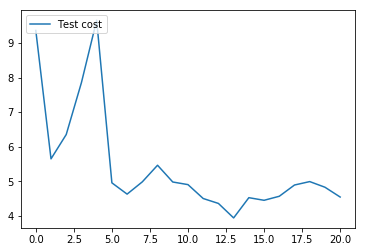

avg_cost: 3.6256474942502463


<Figure size 432x288 with 0 Axes>

In [16]:
train_loop()

In [17]:
infer_movie_id = 783
infer_movie_name = paddle.dataset.movielens.movie_info()[infer_movie_id].title
user_id = fluid.create_lod_tensor([[1]], [[1]], place)
gender_id = fluid.create_lod_tensor([[1]], [[1]], place)
age_id = fluid.create_lod_tensor([[0]], [[1]], place)
job_id = fluid.create_lod_tensor([[10]], [[1]], place)
movie_id = fluid.create_lod_tensor([[783]], [[1]], place) # Hunchback of Notre Dame
category_id = fluid.create_lod_tensor([[10, 8, 9]], [[3]], place) # Animation, Children's, Musical
movie_title = fluid.create_lod_tensor([[1069, 4140, 2923, 710, 988]], [[5]],
                                      place) # 'hunchback','of','notre','dame','the'

In [18]:
place = fluid.CUDAPlace(0) if use_cuda else fluid.CPUPlace()
exe = fluid.Executor(place)

inference_scope = fluid.core.Scope()

In [19]:
with fluid.scope_guard(inference_scope):
    [inferencer, feed_target_names,
    fetch_targets] = fluid.io.load_inference_model(params_dirname, exe)

    results = exe.run(inferencer,
                          feed={
                               'user_id': user_id,
                              'gender_id': gender_id,
                              'age_id': age_id,
                              'job_id': job_id,
                              'movie_id': movie_id,
                              'category_id': category_id,
                              'movie_title': movie_title
                          },
                          fetch_list=fetch_targets,
                          return_numpy=False)
    predict_rating = np.array(results[0])
    print("Predict Rating of user id 1 on movie \"" + infer_movie_name +
              "\" is " + str(predict_rating[0][0]))
    print("Actual Rating of user id 1 on movie \"" + infer_movie_name +
              "\" is 4.")


Predict Rating of user id 1 on movie "Hunchback of Notre Dame, The " is 2.199356
Actual Rating of user id 1 on movie "Hunchback of Notre Dame, The " is 4.
